# Motif enrichment analysis

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "./scripts")
import functions as f
from matplotlib import pyplot as plt
import seaborn as sns
from copy import copy
import multiprocessing as mp
import joblib
from tqdm import tqdm
from scipy import stats

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: gs0.1


### Motifs library

There are conventional denotations for all possible triads as presented below

<img src="./pics/triads.png" width=2000 height=20/>

# Yeast Tnet

In [29]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "yeast")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [30]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [32]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 2.6 s, sys: 137 ms, total: 2.73 s
Wall time: 7.39 s


{'021C': 37631, '021D': 1059856, '021U': 26042, '030C': 8, '030T': 3370}

#### Random networks motif counting

In [11]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 60000

In [9]:
def get_shuffled_mp(params):
    matrix = params["matrix"]
    nswaps = params["nswaps"]
    return f.get_shuffled_matrix(matrix, nswaps)

In [12]:
counters = []
for _ in range(N_STEPS):
    pool = mp.Pool(mp.cpu_count())
    params = {"matrix": interaction_matrix, "nswaps": N_SWAPS}
    shuffled_arrays = pool.map(get_shuffled_mp, (params for _ in range(int(N_SIMS/N_STEPS))))
    pool.close()
    pool.join()
    for arr in tqdm(shuffled_arrays):
        motifs, counter = f.motif_search(cfg, arr, batch_size=10000)
        counters.append(counter)
# joblib.dump(counters, "./networks/yeast/shuffled_counters.gz");

100%|██████████| 100/100 [15:10<00:00,  9.10s/it]


In [13]:
# c = joblib.load("./networks/yeast/shuffled_counters.gz")
# len(c)

1000

#### Z-score and P-value estimation

In [33]:
counters = joblib.load("./networks/yeast/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:03<00:00, 254.38it/s]


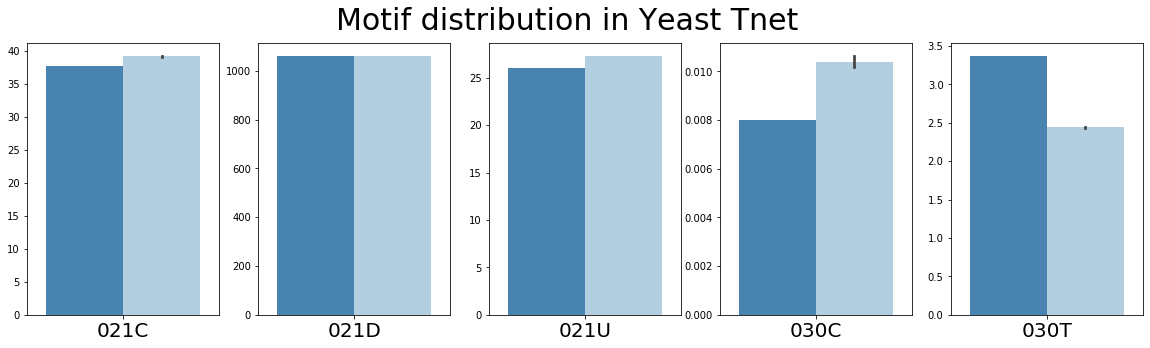

In [34]:
f.plot_distr(counters, counter_orig, label="Motif distribution in Yeast Tnet", highlight=False);

In [35]:
distr = {triad: [] for triad in counters[0].keys()}
for counter in counters:
    for triad, n in counter.items():
        distr[triad].append(n)
distr = {x: np.array(y) for x, y in distr.items()}

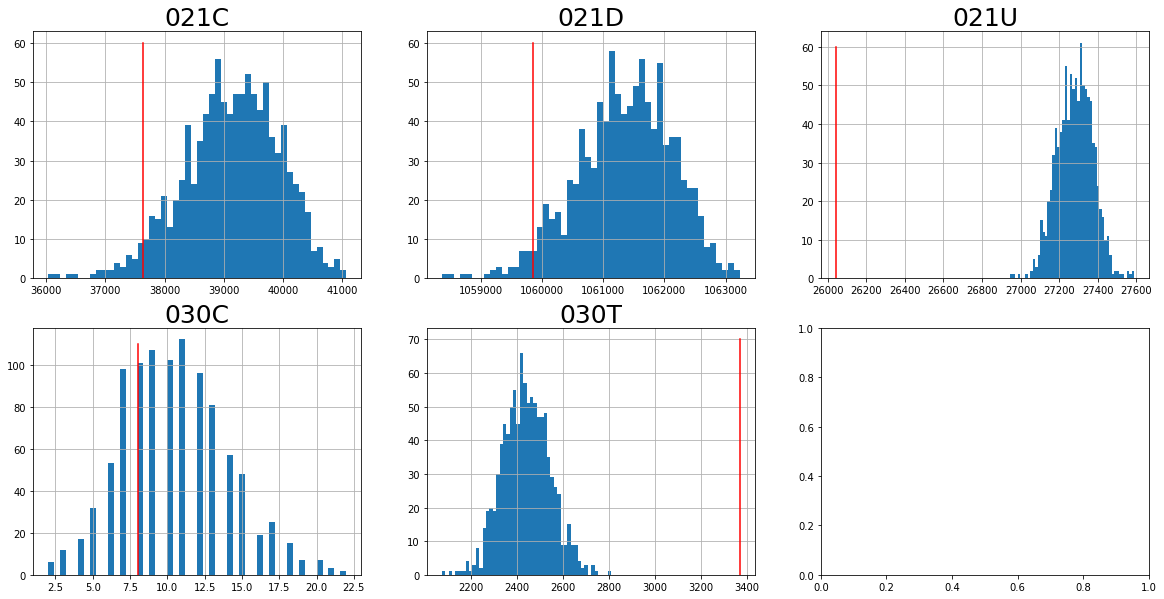

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
ticks = [60, 60, 60, 110, 70]
for i, motif in enumerate(counters[0].keys()):
    ax = axes[i//3, i%3]
    ax.set_title(motif, fontsize=25)
    pd.Series(distr[motif]).hist(bins=50, ax=ax)
    ax.plot([counter_orig[motif]]*100, np.linspace(0, ticks[i], 100), "r")

In [37]:
zscores_report = pd.DataFrame(
    index=["N_real", "mean(N_rand)", "sd(N_rand)", "Z-score", "P-value", "Result"]
)
for motif in counters[0].keys():
    n_hypothesis = len(counters[0].keys())
    d = distr[motif]
    zscore = (counter_orig[motif]-np.mean(distr[motif]))/np.std(distr[motif])
    pvalue = len(d[d <= counter_orig[motif]])/len(d)
    if pvalue > 0.5:
        pvalue = len(d[d >= counter_orig[motif]])/len(d)
    if pvalue < 0.01/n_hypothesis:
        result = " < 0.01"
    elif pvalue < 0.05/n_hypothesis:
        result = " < 0.05"
    else:
        result = "non-significant"
    result_list = [
        counter_orig[motif],
        np.mean(distr[motif]),
        np.std(distr[motif]),
        zscore,
        pvalue,
        result
    ]
    zscores_report[motif] = result_list
zscores_report.T

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,37631,39133.2,798.108,-1.88218,0.036,non-significant
021D,1059856,1.06136e+06,775.767,-1.94061,0.032,non-significant
021U,26042,27282.5,91.95,-13.4915,0,< 0.01
030C,8,10.405,3.54753,-0.677936,0.319,non-significant
030T,3370,2439.5,102.095,9.11403,0,< 0.01


# Ecoli Tnet

In [3]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "ecoli")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: ecoli


In [4]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [5]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 678 ms, sys: 71.2 ms, total: 750 ms
Wall time: 2.65 s


{'021C': 3938, '021D': 329287, '021U': 4365, '030C': 0, '030T': 1392}

#### Random networks motif counting

In [6]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 70000

In [7]:
def get_shuffled_mp(params):
    matrix = params["matrix"]
    nswaps = params["nswaps"]
    return f.get_shuffled_matrix(matrix, nswaps)

In [28]:
counters = []
for _ in range(N_STEPS):
    pool = mp.Pool(mp.cpu_count())
    params = {"matrix": interaction_matrix, "nswaps": N_SWAPS}
    shuffled_arrays = pool.map(get_shuffled_mp, (params for _ in range(int(N_SIMS/N_STEPS))))
    pool.close()
    pool.join()
    for arr in tqdm(shuffled_arrays):
        motifs, counter = f.motif_search(cfg, arr, batch_size=10000)
        counters.append(counter)
# joblib.dump(counters, "./networks/ecoli/shuffled_counters.gz");

In [13]:
c = joblib.load("./networks/ecoli/shuffled_counters.gz")
len(c)

1000

#### Z-score and P-value estimation

In [6]:
counters = joblib.load("./networks/ecoli/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:03<00:00, 258.50it/s]


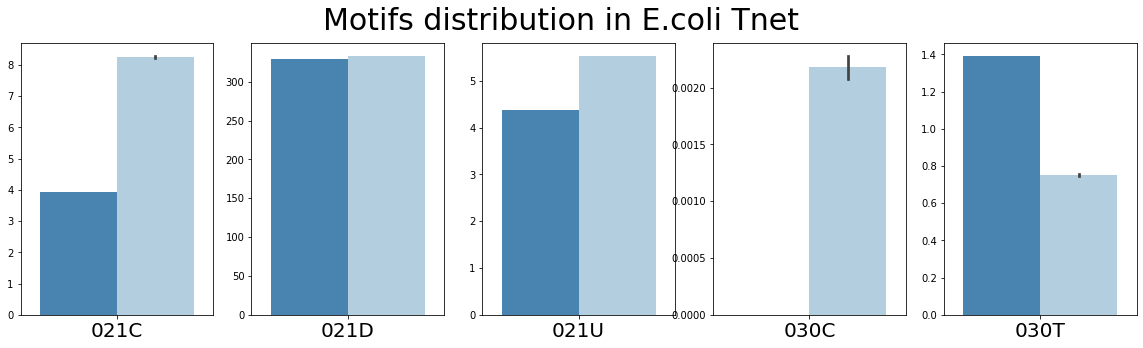

In [15]:
df, fig = f.plot_distr(counters, counter_orig, label="Motifs distribution in E.coli Tnet", highlight=False);

In [8]:
distr = {triad: [] for triad in counters[0].keys()}
for counter in counters:
    for triad, n in counter.items():
        distr[triad].append(n)
distr = {x: np.array(y) for x, y in distr.items()}

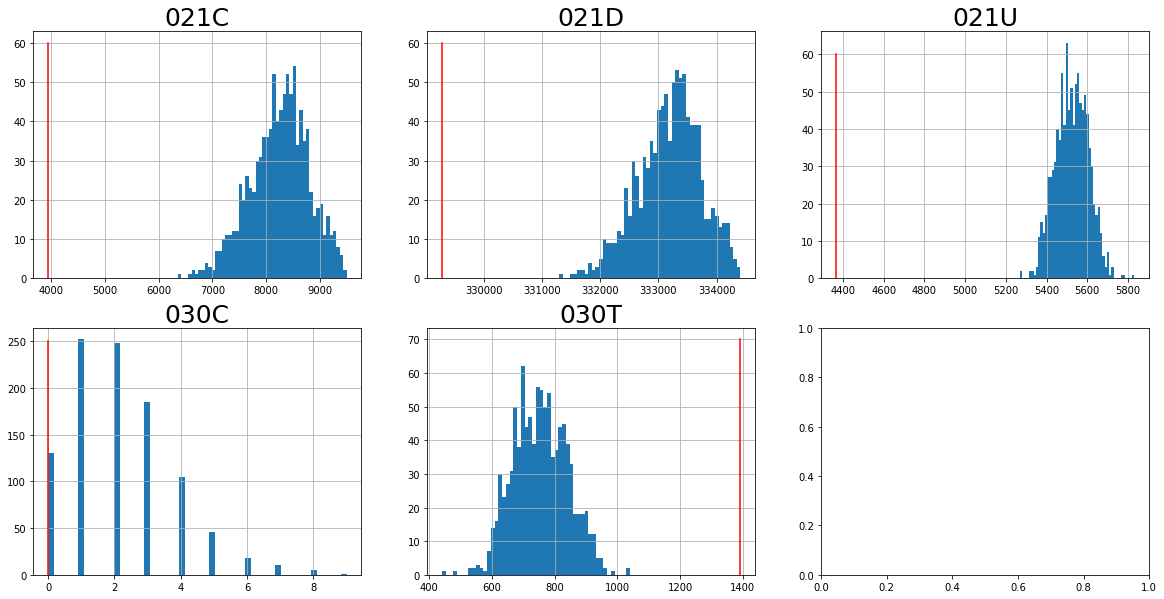

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
ticks = [60, 60, 60, 250, 70]
for i, motif in enumerate(counters[0].keys()):
    ax = axes[i//3, i%3]
    ax.set_title(motif, fontsize=25)
    pd.Series(distr[motif]).hist(bins=50, ax=ax)
    ax.plot([counter_orig[motif]]*100, np.linspace(0, ticks[i], 100), "r")

In [14]:
zscores_report = pd.DataFrame(
    index=["N_real", "mean(N_rand)", "sd(N_rand)", "Z-score", "P-value", "Result"]
)
for motif in counters[0].keys():
    n_hypothesis = len(counters[0].keys())
    d = distr[motif]
    zscore = (counter_orig[motif]-np.mean(distr[motif]))/np.std(distr[motif])
    pvalue = len(d[d <= counter_orig[motif]])/len(d)
    if pvalue > 0.5:
        pvalue = len(d[d >= counter_orig[motif]])/len(d)
    if pvalue < 0.01/n_hypothesis:
        result = " < 0.01"
    elif pvalue < 0.05/n_hypothesis:
        result = " < 0.05"
    else:
        result = "non-significant"
    result_list = [
        counter_orig[motif],
        np.mean(distr[motif]),
        np.std(distr[motif]),
        zscore,
        pvalue,
        result
    ]
    zscores_report[motif] = result_list
zscores_report.T

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,3938,8250.95,544.278,-7.92417,0,< 0.01
021D,329287,333191,537.226,-7.26617,0,< 0.01
021U,4365,5524.94,79.8659,-14.5235,0,< 0.01
030C,0,2.18,1.58921,-1.37175,0.13,non-significant
030T,1392,754.326,86.0515,7.41038,0,< 0.01


# GS 0.1 net

In [3]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "gs0.1")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: gs0.1


In [4]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [5]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 47.2 ms, sys: 42.4 ms, total: 89.6 ms
Wall time: 2.11 s


{'021C': 9459, '021D': 5261, '021U': 4079, '030C': 17, '030T': 73}

#### Random networks motif counting

In [6]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 40000

In [7]:
def get_shuffled_mp(params):
    matrix = params["matrix"]
    nswaps = params["nswaps"]
    return f.get_shuffled_matrix(matrix, nswaps)

In [8]:
counters = []
for _ in range(N_STEPS):
    pool = mp.Pool(mp.cpu_count())
    params = {"matrix": interaction_matrix, "nswaps": N_SWAPS}
    shuffled_arrays = pool.map(get_shuffled_mp, (params for _ in range(int(N_SIMS/N_STEPS))))
    pool.close()
    pool.join()
    for arr in tqdm(shuffled_arrays):
        motifs, counter = f.motif_search(cfg, arr, batch_size=10000)
        counters.append(counter)
joblib.dump(counters, "./networks/gs0.1/shuffled_counters.gz");

100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


In [11]:
# c = joblib.load("./networks/ecoli/shuffled_counters.gz")
# c[:100]

#### Z-score and P-value estimation

In [12]:
counters = joblib.load("./networks/gs0.1/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:03<00:00, 268.42it/s]


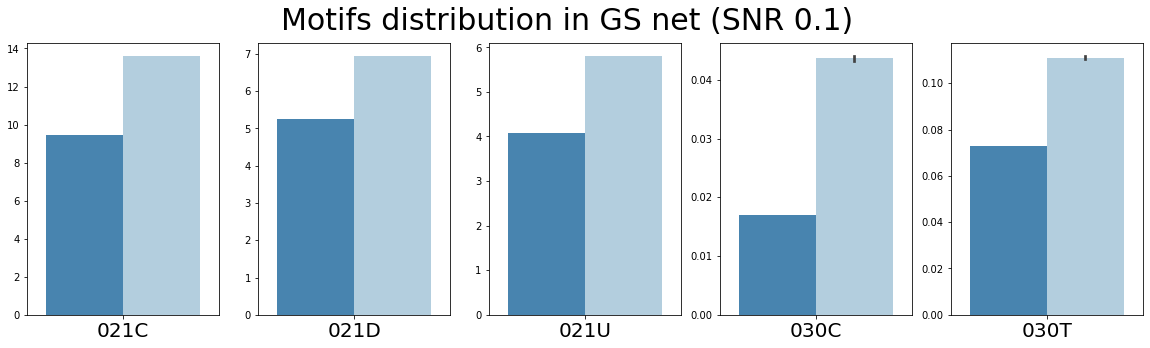

In [13]:
f.plot_distr(counters, counter_orig, label="Motifs distribution in GS net (SNR 0.1)", highlight=False);

In [14]:
distr = {triad: [] for triad in counters[0].keys()}
for counter in counters:
    for triad, n in counter.items():
        distr[triad].append(n)
distr = {x: np.array(y) for x, y in distr.items()}

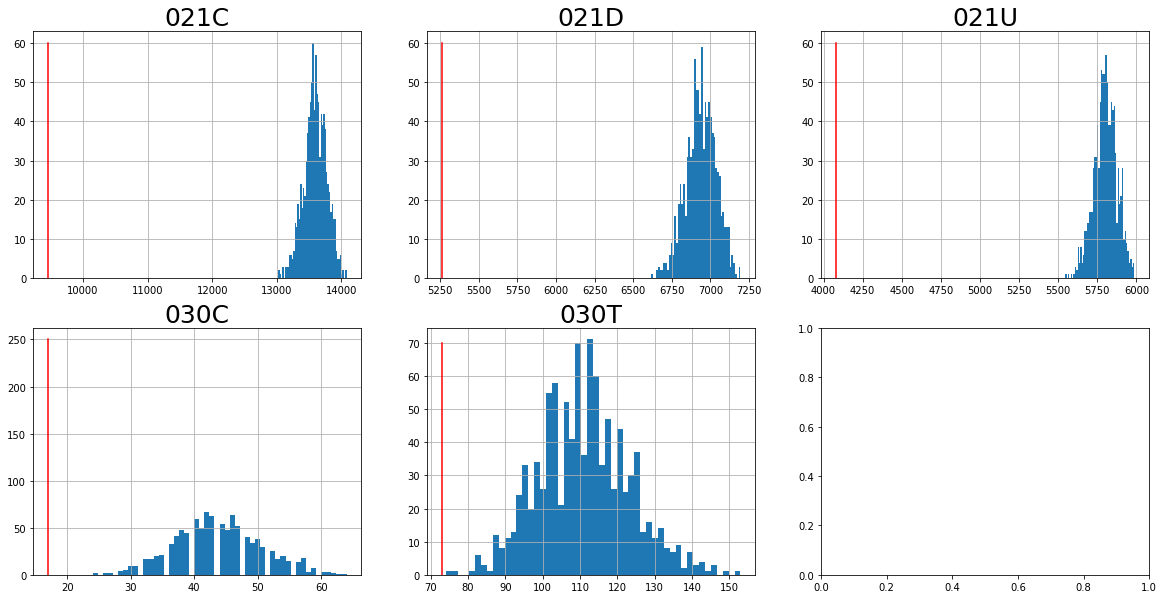

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
ticks = [60, 60, 60, 250, 70]
for i, motif in enumerate(counters[0].keys()):
    ax = axes[i//3, i%3]
    ax.set_title(motif, fontsize=25)
    pd.Series(distr[motif]).hist(bins=50, ax=ax)
    ax.plot([counter_orig[motif]]*100, np.linspace(0, ticks[i], 100), "r")

In [16]:
zscores_report = pd.DataFrame(
    index=["N_real", "mean(N_rand)", "sd(N_rand)", "Z-score", "P-value", "Result"]
)
for motif in counters[0].keys():
    n_hypothesis = len(counters[0].keys())
    d = distr[motif]
    zscore = (counter_orig[motif]-np.mean(distr[motif]))/np.std(distr[motif])
    pvalue = len(d[d <= counter_orig[motif]])/len(d)
    if pvalue > 0.5:
        pvalue = len(d[d >= counter_orig[motif]])/len(d)
    if pvalue < 0.01/n_hypothesis:
        result = " < 0.01"
    elif pvalue < 0.05/n_hypothesis:
        result = " < 0.05"
    else:
        result = "non-significant"
    result_list = [
        counter_orig[motif],
        np.mean(distr[motif]),
        np.std(distr[motif]),
        zscore,
        pvalue,
        result
    ]
    zscores_report[motif] = result_list
zscores_report.T

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,9459,13594.9,175.585,-23.5552,0,< 0.01
021D,5261,6937.75,97.3987,-17.2153,0,< 0.01
021U,4079,5801.72,73.102,-23.566,0,< 0.01
030C,17,43.626,6.80824,-3.91085,0,< 0.01
030T,73,111.069,12.1616,-3.13027,0,< 0.01
